## Using Carrol's (2005) Endogenous Grid Method

This notebook provides code for the endogenous grid method. Although readability over efficiency is prioritized, it still solves the income fluctuations problem (for a given real rate) in less than half a second.

In [5]:
include("rowenhorst_tauchen.jl") # include discretization functions (make sure it is in your working directory)

tauchen (generic function with 1 method)

We begin with a tuple that holds the household parameters.

In [6]:
using Parameters, Plots, LinearAlgebra, Interpolations, BenchmarkTools

Household = @with_kw (apoints = 500, #asset grid
    amax = 200,  # asset max
    beta = 0.98, # discount factor
    alpha = 0.11, # capital share
    deprec = 0.025, # depreciation rate
    gamma = 1, # elasticity of substitution
    bc = 0, # borrowing constraint (must be weakly negative)
    rho = 0.966,  # autocorr of income process
    num_states = 7, # number of states for income process
    sd = 0.13, # stand. dev. of deviation process
    mean = 0, # mean of income process
    uncond_sd = 0.13/sqrt(1-rho^2), # unconditional sd
    transition_matrix = rowenhorst(mean, uncond_sd, rho, num_states)[1], # transition matrix
    ygrid = rowenhorst(mean, uncond_sd, rho, num_states)[2], # grid for income process
    Amat = setgrids(bc, apoints, amax, num_states, ygrid)[1], # asset grid
    Ymat = setgrids(bc, apoints, amax, num_states, ygrid)[2]) # income grid


function setgrids(bc, apoints, amax, num_states, ygrid)
    Amat = [i for i in range(bc, length = apoints, stop= amax), j in 1:num_states]
    Ymat = [j for i = 1:apoints, j in ygrid]
    return Amat, Ymat
end

hh = Household()

(apoints = 500, amax = 200, beta = 0.98, alpha = 0.11, deprec = 0.025, gamma = 1, bc = 0, rho = 0.966, num_states = 7, sd = 0.13, mean = 0, uncond_sd = 0.5028195291614176, transition_matrix = [0.9022379843199956 0.09361981119088468 … 8.374316586000039e-9 2.4137569000000128e-11; 0.015603301865147443 0.9035872016735433 … 4.0355125541400147e-7 1.3957194310000061e-9; … ; 1.3957194310000061e-9 4.0355125541400147e-7 … 0.9035872016735433 0.015603301865147443; 2.4137569000000125e-11 8.374316586000037e-9 … 0.09361981119088467 0.9022379843199955], ygrid = [0.25738376293233367, 0.38804396244888767, 0.5850334732755494, 0.8820241982193845, 1.3297814941917474, 2.0048416198384222, 3.022594266947119], Amat = [0.0 0.0 … 0.0 0.0; 0.40080160320641284 0.40080160320641284 … 0.40080160320641284 0.40080160320641284; … ; 199.59919839679358 199.59919839679358 … 199.59919839679358 199.59919839679358; 200.0 200.0 … 200.0 200.0], Ymat = [0.25738376293233367 0.38804396244888767 … 2.0048416198384222 3.0225942669471

Next, some useful functions that will be used in the main EGM function.

In [7]:
# marginal utilities and their inverses

up(c,gamma) = c.^(-gamma)
invup(x,gamma) = x.^(-1/gamma)

# euler equation to get current consumption given future interest rate and future consumption grid

function getc(gamma,beta,transition_matrix; rnext,cnext)
    upnext = beta.*(1+rnext).*up(cnext,gamma)*transition_matrix' # future marginal utility
    c = invup(upnext,gamma) # current consumption
    return c
end

# obtain current assets given consumption today defined on asset grid tomorrow

geta(Amat,Ymat; r,w,c) =  1/(1+r).*(c.+Amat.-w.*Ymat)

# obtain aggregates

function getcapital(; policyfun, dist)
    K = reshape(policyfun, (length(dist),1))
    K = sum(K.*dist)
    return K
end

function getconsumption(; cpolicy, dist)
    C = reshape(cpolicy, (length(dist),1)) 
    C = sum(C.*dist)
    return C
end

getconsumption (generic function with 1 method)

This is the main egm function. It iterates on the Euler equation $c_t = \beta (1+r_{t+1}) \mathbb{E}_t c_{t+1}$ given a guess for the consumption policy function $c_{t+1}$ ("cnext" in the function). Observe that we no longer need a root finding procedure, but still need to interpolate the optimal policy on our defined grids.

In [8]:
# Note: function takes both current and future interest rates as arguments.

function egm(hh; w, cnext, cbinding, r, rnext)
 """
    use endogenous grid method to obtain c_{t} and a_{t} given c_{t+1} 'cnext'
    
    #### Fields
    
    - 'hh': household tuple
    - 'w': wage rate
    - 'cnext': time t+1 consumption grid
    - 'cbinding': consumption grid when borrowing constraint binds
    - 'r': interest rate at time t
    - 'rnext': interest rate at time t+1
    
    #### Returns
    
    - 'c': time t consumption grid
    - 'anext': time t policy function
    
"""
    
@unpack gamma, beta, transition_matrix, Amat, Ymat, num_states = hh

# current policy functions on current grid
c = getc(gamma, beta, transition_matrix; rnext=rnext, cnext=cnext)
a = geta(Amat, Ymat; r=r, w=w, c=c)

cnonbinding = similar(Amat)
    
# get consumption policy function for current grid
for i = 1:num_states
    cnonbinding[:,i] = LinearInterpolation(a[:,i], c[:,i], extrapolation_bc = Line()).(Amat[:,i])
end

# update elements of consumption policy when borrowing constraint binds
# a[1,j] is the level of current assets that induces the borrowing constraint to bind exactly.
# Therefore, whenever current assets are below a[1,j], the borrowing constraint will be STRICTLY binding.
# Note that this uses the monotonicity of the policy rule.

for j = 1:num_states
   c[:,j] = (Amat[:,j] .> a[1,j]) .*cnonbinding[:,j] .+ (Amat[:,j] .<= a[1,j]).*cbinding[:,j]
end
    
# update saving policy function with new consumption function
anext = @. (1+r)*Amat + w*Ymat - c

return c, anext
end

egm (generic function with 1 method)

This is the function that iterates on the EGM function above to solve for the optimal policy rule.

In [19]:
function iterate_egm(hh; r, tol=1e-8, maxiter=1000)
    @unpack deprec, alpha, Amat, Ymat, bc = hh
    
    Z = ((r + deprec)/alpha)^alpha # normalize aggregate income so that Y=1
    w = (1-alpha)*Z*(alpha*Z/(r+deprec))^(alpha/(1-alpha)) # wage rate given guess for r
     
    cnext = @. r*Amat+Ymat*w # initial guess for policy function iteration 
    
    cbinding = @. (1+r)*Amat + w*Ymat - bc # get consumption when borrowing constraint binds
    
    dist = 1
    counter = 0
    
    for i=1:maxiter
        c = egm(hh; w=w, rnext=r, r=r, cnext=cnext, cbinding=cbinding)[1]
        if norm(c-cnext,Inf)<tol 
            println("policy function iteration successful!")
            return egm(hh; w=w, rnext=r, r=r, cnext=c, cbinding=cbinding)
        else
            cnext = c
        end
    end
    
    error("no policy function convergence!")
    
end

iterate_egm (generic function with 1 method)

Solves for the optimal policy in $\approx$ half a second.

In [28]:
@btime iterate_egm(hh, r = 0.01)

policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy funct

([0.229071549009777 0.34535912657951007 … 1.3943103414863514 1.7725763508363424; 0.29940986080156645 0.4157540956950566 … 1.4104899164445726 1.785396400040648; … ; 5.205973695955185 5.29850225815569 … 5.959082647524173 6.252787262528742; 5.214368589072018 5.30689479899247 … 5.967454358337173 6.261149782473624], [0.0 0.0 … 0.3899987001698446 0.917532546746594; 0.33447130744668746 0.3344146501229305 … 0.7786287444501003 1.3095221167807656; … ; 196.61828823381612 196.64204724918537 … 197.42041677489354 198.0325120158157; 197.01470295993775 197.03846432758706 … 197.81685468331904 198.4289591151093])

policy function iteration successful!


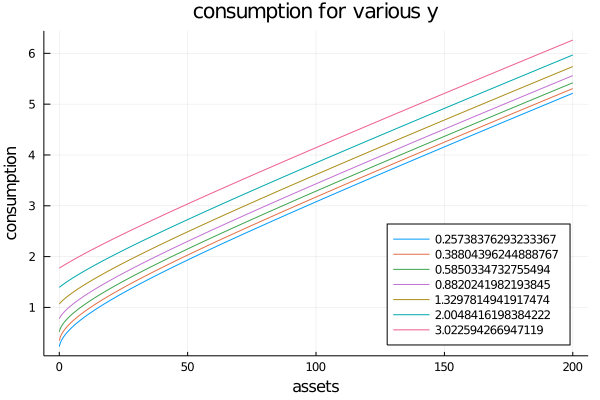

In [29]:
@unpack Amat, ygrid = hh

c, policyfun = iterate_egm(hh, r = 0.01)

plot(Amat[:,1], c, label = ygrid', xlabel = "assets", ylabel = "consumption", title = "consumption for various y", legend = :bottomright)


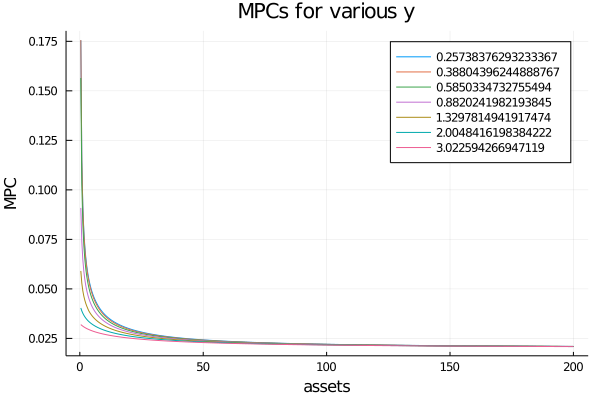

In [30]:
function MPC(a, grid)
    b = similar(a)
    b[1] = 0
    for i = 2:length(a)
         b[i] = (a[i] - a[i-1])/(grid[i] - grid[i-1])
    end
    return b
end

p = plot()
for i = 1:length(c[1,:])
    prop = MPC(c[:,i],Amat[:,1])
    plot!(p, Amat[2:end,1], prop[2:end])
end

plot(p, xlabel = "assets", ylabel = "MPC", title = "MPCs for various y", label = ygrid')